# DSCI 100 Group Project Proposal

team: Rachel Liang, Ziyan He, Yuchen Zhang, Zohane Bal

In [4]:
### Run this cell before continuing. 
library(tidyverse)
# library(digest)
# library(repr)
library(tidymodels)
library(GGally)
library(ggplot2)
# library(ISLR)
options(repr.matrix.max.rows = 6)
# source("cleanup.R")

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



### Introduction    

The dataset we are working on is downloaded from the UCI Machine Learning Repository. Although the dataset contains four databases about the heart disease diagnosis from 4 different locations, we only picked the database collected from the Cleveland Clinic Foundation since it is the only data base that has full 14 attributes recored for each heart disease diagnosis. The total instances in this database is 303.

# Method and Result

### Load Data and Wrangle Data
This dataset does not need to be cleaned since it does not have any missing data or missing attributes. <br>
We added column names to the dataset and selected columns we needed for analysis. Also as we are treating some attributes's numeric values as categorical variables, we used as.factor() for conversion.

In [5]:
set.seed(1234)

heart_disease_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"


heart_disease_data <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num"))
heart_disease_data

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


### 14 Attributes Description
* Age: age in years
* Sex: ( 1 = male, 0 = female)
* Cp: chest pain type
Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4 asymptomatic
* Trestbps: Resting Blood pressure ( in mm Hg on admission to hospital)
* Chol: Serum cholesterol in mg/dl
* Fbs: Fastig blood suger > 120 (1 = true, 0 = false)
* Dm: 1 = history if diabetes , 0 = no such history)
* Restecg: Resting electro cardiac results
Value 0 : normal
Value 1: having ST-T wave abnormality ( T wave inversion and/or ST elevation or depression of > 0.05 mV)
Value 2” Showing probable or definite left ventricular hypertrophy by Estes’ criteria
* Thalach: maximum heart rate achieved
* Exang: exercise induced angina (1 = yes ,0 = no)
* Oldpeak:ST depression induced by exercise relative to rest
* Slope: The slope of the peak exercise ST segment
Value 1: upsloping
Value 2: flat
Value 3: downsloping
* Ca: Number of major vessels (0-3) coloured by fluorosopy
* Thal: 3 = normal , 6= fixed defect , 7 = reversible defect
* Num: diagnosis of heart disease
Value 0 <50% diameter narrowing
Value 1 > 50% Diameter narrowing

### Observation from the Correlation Plot
Through the correlation plot we found five predictors with relatively large absolute correlation value, which are cp, thalach, exang, oldpeak, and slope.<br> We excluded the two factors which are age and sex that we thought would have a great influence on the target variable, num. In the end, having the above five predictors chosen to predict the presence of heart disease.

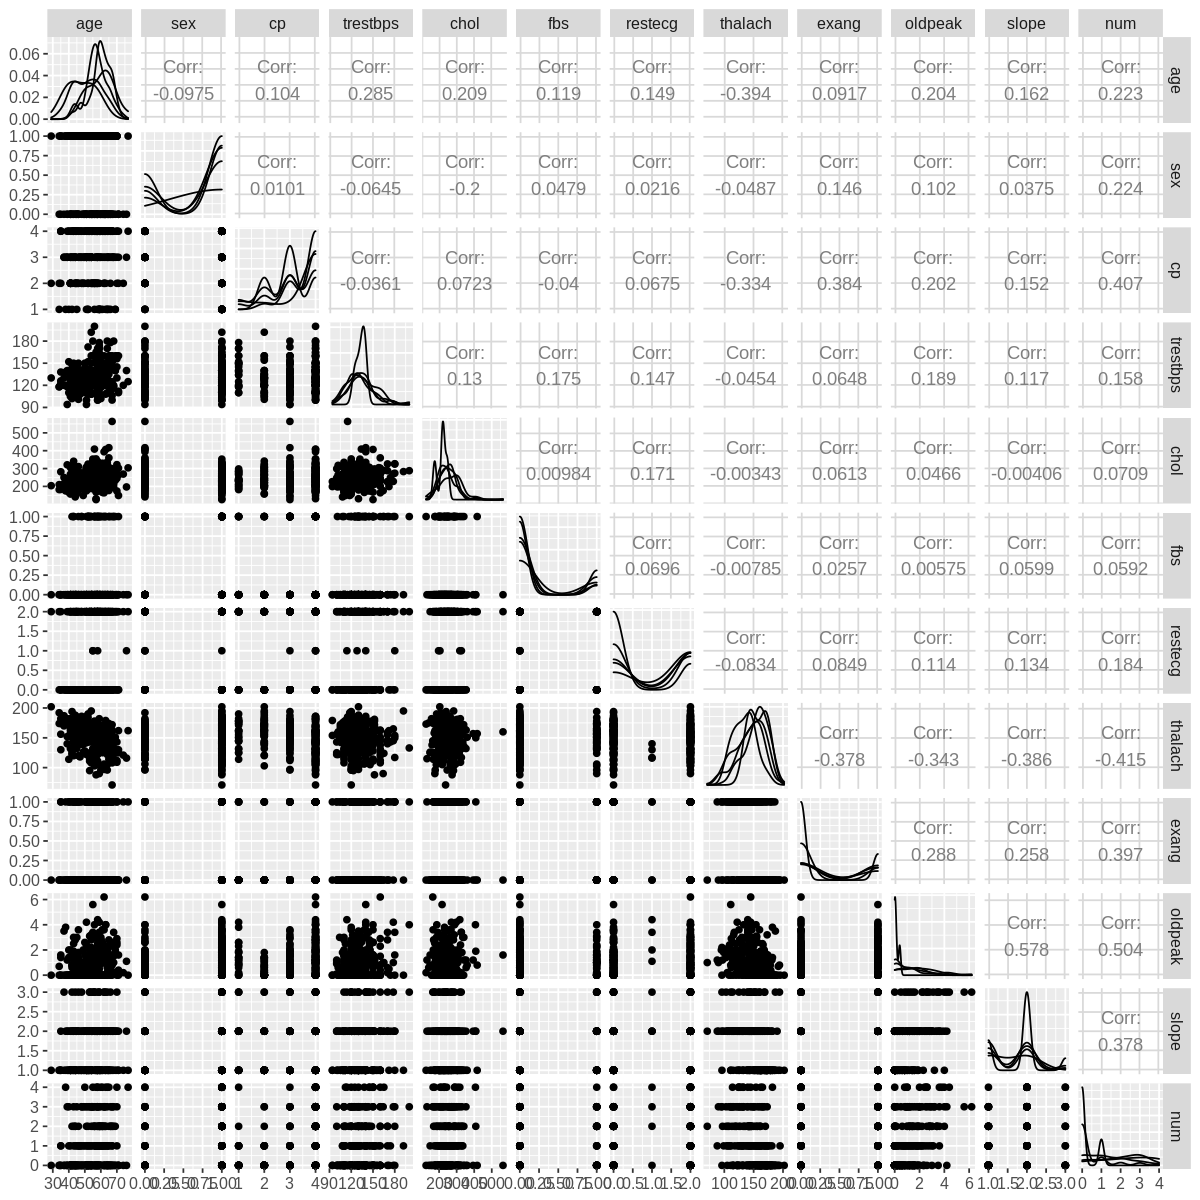

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10)
correlation_plot <- heart_disease_data %>% 
                select(-ca, -thal) %>% 
                ggpairs(heart_disease_data[1:12]) +
                theme(text = element_text(size = 12))


correlation_plot

### Some visualizations of the dataset
Based on the ggparis correlation plot, we found that the correlation between cp and presence of heart disease (the target variable) is relatively high; therefore, we chose to plot a graph to show the correlation between these two values.

We try to visualize which type of chest pain occurs most often in different levels of heart disease(0 meaning zero probability of having heart diseanse, and 4 meaning the most probability of having a heart disease).<br>

We observed that individuals having type 4 chest pain which is asymptomatic chest pain, have the most probobility(4) of having heart disease.

`summarise()` regrouping output by 'num' (override with `.groups` argument)



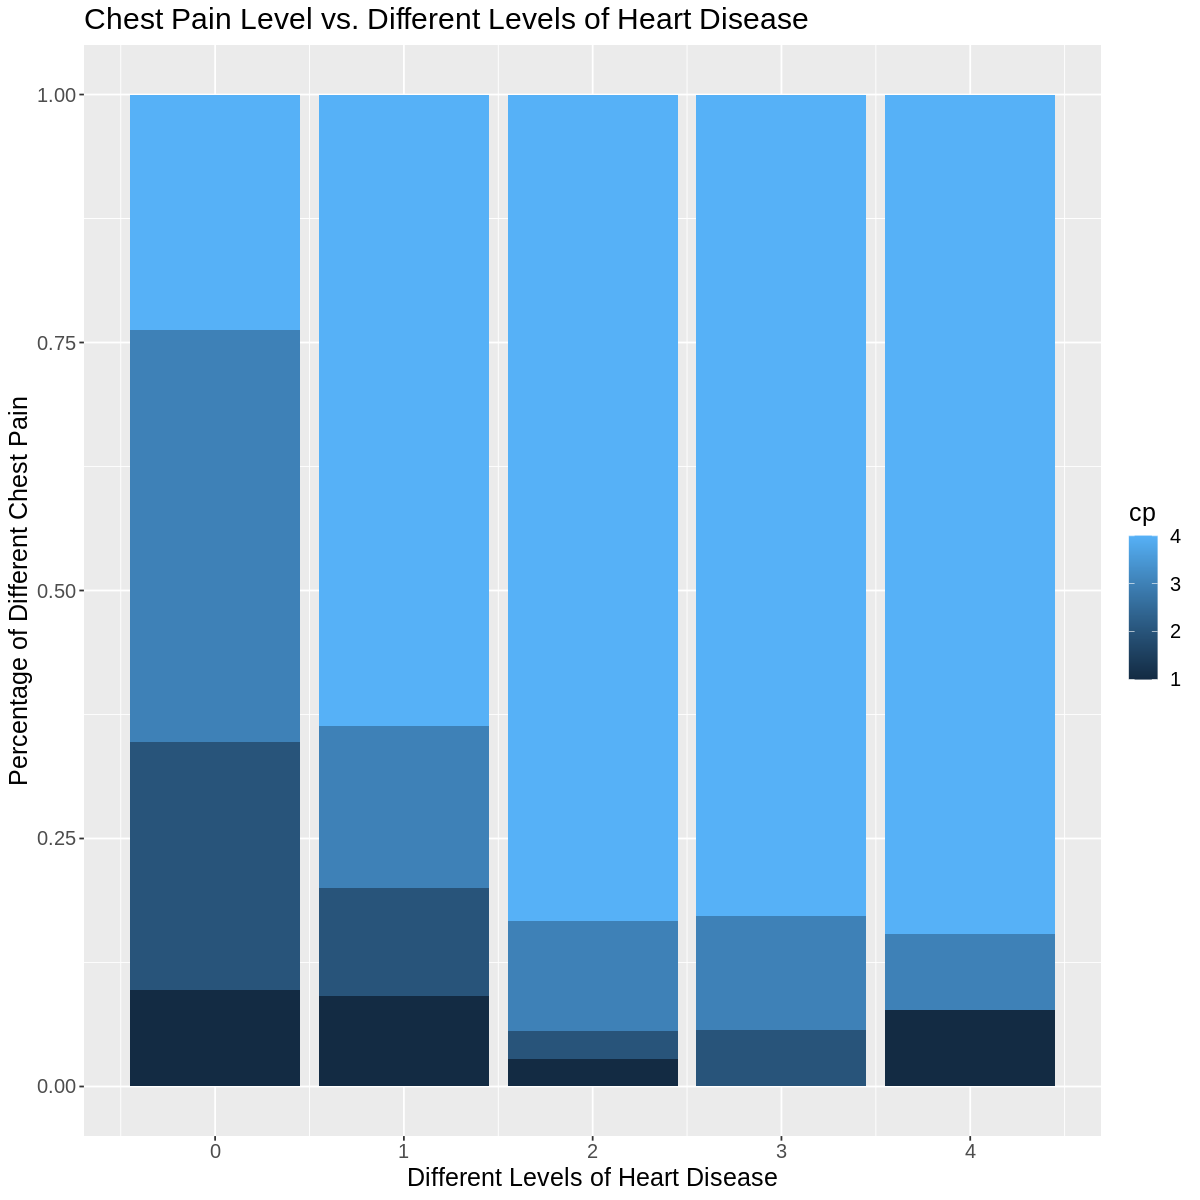

In [7]:
# options(repr.plot.width = 7, repr.plot.height = 7)

cp_vs_num <- heart_disease_data %>% 
            select(num, cp) %>% 
            group_by(num, cp) %>% 
            summarize(n = n()) %>%
            ggplot(aes(x = num, y = n, fill = cp)) +
            labs(x="Different Levels of Heart Disease", y= "Percentage of Different Chest Pain")+
            geom_bar(stat = "identity",position = "fill") +
            ggtitle("Chest Pain Level vs. Different Levels of Heart Disease")+
            theme(text = element_text(size = 15))
cp_vs_num

In [8]:
# thalach_vs_num <- heart_disease_data %>% 
#             select(num, thalach) %>% 
#             group_by(num, thalach) %>% 
#             summarize(n = n()) %>%
#             ggplot(aes(x = num, y = n, fill = thalach)) +
#             geom_bar(stat = "identity",position = "fill")
# thalach_vs_num

### Check for balancing

We summarize the counts for the target variable, num, and calcuated the percentage of each level of presence of heart disease. And we found that the percentage of num = 0 (having no presence of heart disease) dominates more than half of the dataset. Therefore, it implies that the dataset is imbalanced. 

<!-- We found the count and percentage of the probability of getting heart disease diagnosis observations in our data set. We observed that our heart disease data set has this “num” (presence of heart disease) imbalance, that is, we have the class, the zero chance of getting heart disease label, more common than the others. We therefore resolve this issue by grouping all the non-zero probability levels of having heart diseases into one group. Thus, we will now have num having two classes. -->

In [9]:
num_obs <- nrow(heart_disease_data)
        heart_disease_data %>% 
        group_by(num) %>% 
        summarize(
        count = n(),
        percentage = n() / num_obs * 100)

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<dbl>,<int>,<dbl>
0,164,54.125413
1,55,18.151815
2,36,11.881188
3,35,11.551155
4,13,4.290429


We therefore resolve this issue by grouping all the non-zero probability levels of having heart diseases into one group. Thus, we will now have num of two classes (0 and 1). 0 represents having no presence of heart disease. 1 represents having presence of heart disease. 

In [10]:
heart_disease_data_5 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    mutate(num = replace(num, num =='2',1)) %>% 
                    mutate(num = replace(num, num =='3',1)) %>% 
                    mutate(num = replace(num, num =='4',1)) %>% 
                    select(cp, thalach, exang, slope, oldpeak, num) %>% 
                    mutate(num = as.factor(num))
                    
heart_disease_data_5                

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,1
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,115,1,2,1.2,1
2,174,0,2,0.0,1
3,173,0,1,0.0,0


### Check for balancing new

In [11]:
num_obs_5 <- nrow(heart_disease_data_5)
        heart_disease_data_5 %>% 
        group_by(num) %>% 
        summarize(
        count = n(),
        percentage = n() / num_obs_5 * 100)

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<fct>,<int>,<dbl>
0,164,54.12541
1,139,45.87459


### Split Into Training and Testing Dataset
Based on the number of instances in this dataset, we decided that setting 75% of the data in the dataset as training data and the remaining 25% as testing data will make a good balance for training the classifier and evaluating the classifier's accuracy, and it is a standardized way of data splitting. 

## Mutating Num to binary categorical

In [12]:
heart_disease_data_5 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    mutate(num = replace(num, num =='2',1)) %>% 
                    mutate(num = replace(num, num =='3',1)) %>% 
                    mutate(num = replace(num, num =='4',1)) %>% 
                    mutate(num = as.factor(num)) %>%  
                    select(cp, thalach, exang, slope, oldpeak, num) 
heart_disease_data_5   

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,1
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,115,1,2,1.2,1
2,174,0,2,0.0,1
3,173,0,1,0.0,0


## Check for balancing

In [13]:
num_obs_5 <- nrow(heart_disease_data_5)
        heart_disease_data_5 %>% 
        group_by(num) %>% 
        summarize(
        count = n(),
        percentage = n() / num_obs_5 * 100)

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<fct>,<int>,<dbl>
0,164,54.12541
1,139,45.87459


## Spliting and training data

In [14]:
set.seed(1234)
heart_disease_split_mut <- initial_split(heart_disease_data_5, prop = 0.75, strata = num)
heart_disease_train_mut <- training(heart_disease_split_mut)
heart_disease_test_mut <- testing(heart_disease_split_mut)

head(heart_disease_data_5, 10)

cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,1
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,163,1,1,0.6,0
4,147,0,2,1.4,1
4,155,1,3,3.1,1


## Create model

We are using classification model because num, the target variable, is a factor representing different probabilities of presence of heart disease. 

In [15]:
knn_spec_mut <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification") 
knn_spec_mut

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We added the step_scale and step_center steps for all predictors when creating the recipe. Therefore, all predictors will each have a mean of 0 and standard deviation of 1. This ensure all data observations will be on a comparable scale and contribute equal shares to the calculation of the distance between points.

In [16]:
heart_recipe_mut <- recipe(num ~ ., data = heart_disease_train_mut)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

Since we have splitted 75% of the dataset to be the train data, and 25% of the dataset to be the test data. 5 folds in cross validation will provide sufficient sample data size for us to train the classifier.

In [17]:
heart_disease_vfold_mut <- vfold_cv(heart_disease_train_mut, v = 5, strata = num)


In [18]:
k_lots_mut <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_fit_mut <- workflow() %>% 
            add_recipe(heart_recipe_mut) %>% 
            add_model(knn_spec_mut) %>% 
            tune_grid(resamples = heart_disease_vfold_mut, grid = k_lots_mut) 

In [19]:
heart_disease_metrics_mut <- knn_fit_mut %>% 
                        collect_metrics()

accuracies_mut <- heart_disease_metrics_mut %>% 
        filter(.metric == "accuracy") 
accuracies_mut
    
# accuracy_vs_k_mut <- ggplot(accuracies_mut, aes(x = neighbors, y = mean)) +
#   geom_point() +
#   geom_line() +
#   labs(x = "Neighbors", y = "Accuracy Estimate") +
#   theme(text = element_text(size = 12))

# accuracy_vs_k_mut

# accuracies_final_mut <- heart_disease_metrics_mut %>% 
#         filter(.metric == "accuracy") %>% 
#         arrange(mean) %>% 
#         tail(1)
# accuracies_final_mut

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7285024,5,0.02711991,Model01
2,accuracy,binary,0.7285024,5,0.02711991,Model02
3,accuracy,binary,0.7022222,5,0.02322089,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,binary,0.7850242,5,0.004950218,Model48
49,accuracy,binary,0.7850242,5,0.008471342,Model49
50,accuracy,binary,0.7850242,5,0.008471342,Model50


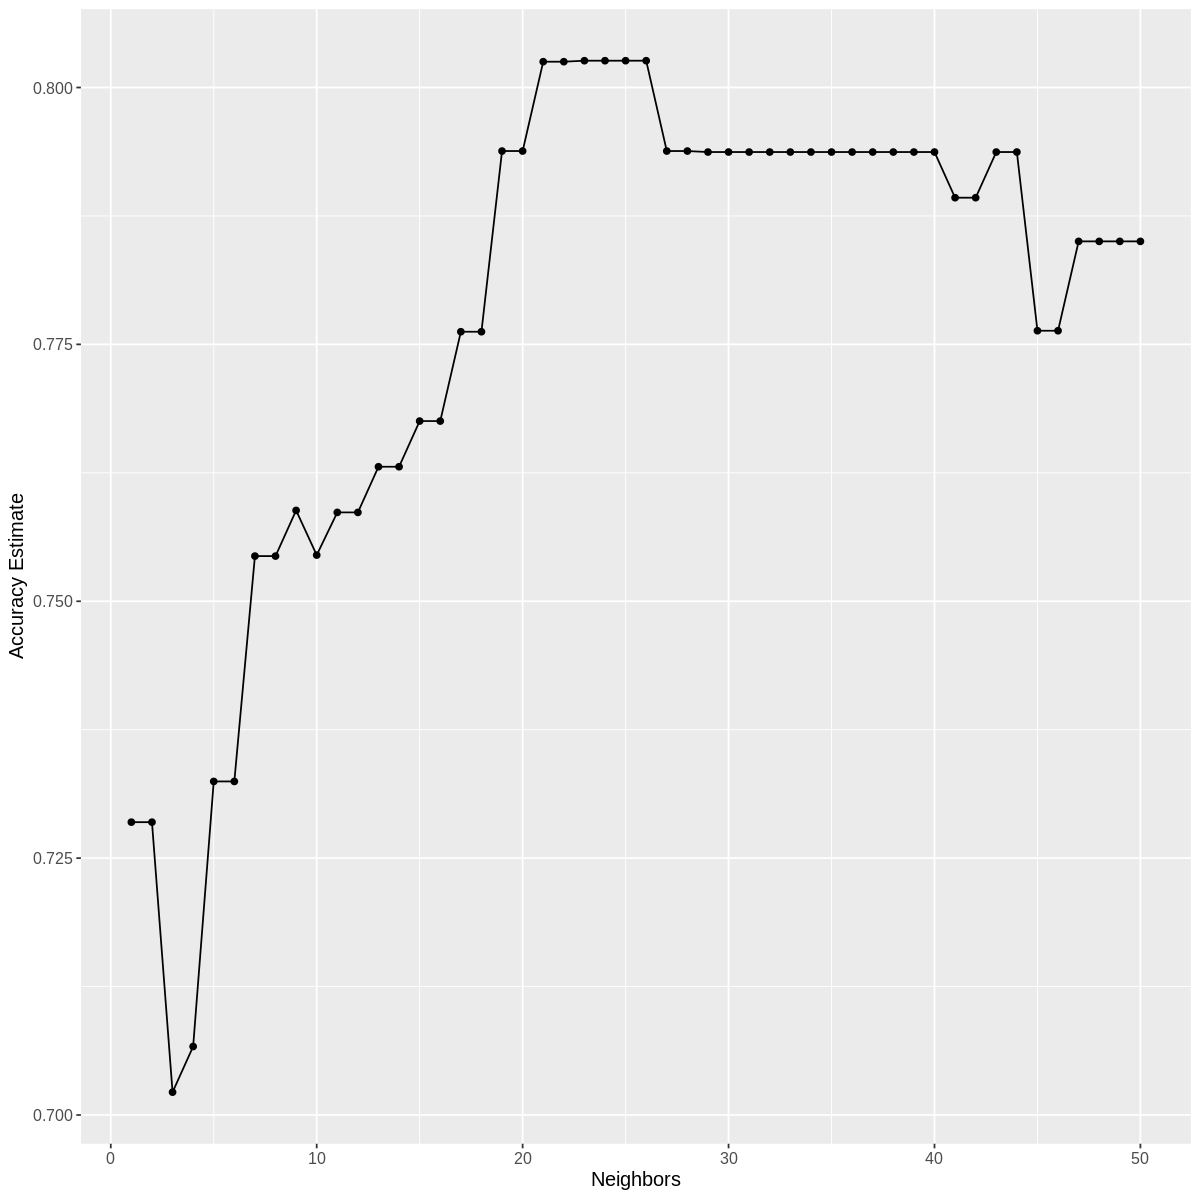

In [20]:
accuracy_vs_k_mut <- ggplot(accuracies_mut, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k_mut

In [21]:
accuracies_final_mut <- heart_disease_metrics_mut %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)
accuracies_final_mut

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
26,accuracy,binary,0.8026087,5,0.01386701,Model26


In [22]:
knn_spec_mut <- nearest_neighbor(weight_func = "rectangular", neighbors = 26) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")
knn_spec_mut

knn_fit_mut <- workflow() %>% 
  add_recipe(heart_recipe_mut) %>% 
  add_model(knn_spec_mut) %>% 
  fit(data = heart_disease_train_mut)
knn_fit_mut

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 26
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~26, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2324561
Best kernel: rectangular
Best k: 26

In [23]:
heart_prediction_mut <- predict(knn_fit_mut, heart_disease_test_mut) %>% 
                    bind_cols(heart_disease_test_mut)

heart_metrics_mut <- heart_prediction_mut %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat_mut <- heart_prediction_mut %>% 
                 conf_mat(truth = num, estimate = .pred_class) 

heart_prediction_mut
heart_metrics_mut
mnist_conf_mat_mut


.pred_class,cp,thalach,exang,slope,oldpeak,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,3,187,0,3,3.5,0
0,2,178,0,1,0.8,0
1,4,160,0,3,3.6,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,4,90,0,2,1.0,1
1,4,123,1,2,0.2,1
1,4,141,0,2,3.4,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8133333


          Truth
Prediction  0  1
         0 35  8
         1  6 26

## FINAL Visualization

### OK To not add a legend for confusion matrix?  --> library(cvms)
### Need any explanation for confusion matrix? 

In [ ]:
# library(yardstick)
# library(ggplot2)
# library(tibble) 
# library(cvms)

autoplot(mnist_conf_mat_mut, type = "heatmap") +
scale_fill_gradient(low = "pink", high = "cyan") +
theme(text = element_text(size = 15)) +
ggtitle("Confusion matrix") 

# value <- plot_confusion_matrix(mnist_conf_mat_mut, 
#                       target_col = "target", 
#                       prediction_col = "prediction",
#                       counts_col = "n")
# value

*Figure 4: Confusion matrix*

The confusion matrix shows 35 cases correctly predicted as patient not having heart disease, and 26 cases correctly predicted as patients having heart disease. It also showed that the classifier makes some mistakes. In particular, it classified 6 cases as patient having heart disease which actually they don't have heart disease; in addition, it classified 8 cases with patients as not having heart disease but actually they have heart disease.  

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 7)


two_predictors_ <- heart_prediction_mut %>%
  ggplot(aes(x = thalach, y = oldpeak, color = .pred_class)) +
  geom_point(alpha = 0.8) +
  labs(color = "predicted heart disease class") +
  scale_color_manual(labels = c("0: no presence of heart disease", "1: presence of heart disease"), 
                     values = c("orange2", "steelblue2")) + 
  theme(text = element_text(size = 15))+
  ggtitle("Scatter plot of thalach versus oldpeak colored by presence of heart disease.")

two_predictors_

*Figure 3: Scatter plot of thalach versus oldpeak colored by presence of heart disease.*

Thalach is the maximum heart rate achieved. Oldpeak means ST depression induced by exercise relative to rest, which is the most reliable indicator of exercise-induced ischaemia (ischaemia means that blood flow to the heart is reduced). Among the correlations between five predictors we have chosen, oldpeak and thalach have relatively high correlation between one and other. Therefore, we chose to plot this graph and use these predictors to illustrate the prediction of presence of heart disease. 

This graph shows that with higher thalach level and lower oldpeak level, the patient is less likely to have a presence of heart disease. Whereas patients with relatively lower level of thalach and higher oldpeak level, there is a higher probability of having presence of heart disease.

In [ ]:
# options(repr.plot.width = 8, repr.plot.height = 8)


# two_predictors_111 <- heart_prediction_mut %>%
#     mutate(slope = as.factor(slope)) %>% 
#   ggplot(aes(x = slope, y = oldpeak, color = .pred_class)) +
#   geom_boxplot() +
#   theme(text = element_text(size = 17))+
#   ggtitle("Box plot of oldpeak versus slope colored by presence of heart disease")

# two_predictors_111

In [ ]:
# *Figure 4: Box plot of oldpeak versus slope colored by presence of heart disease.*

In [ ]:
# We infer that when an indivisual has the slope of the peak exercise ST segment Value at 2, then there is a high chance that the individual will have a presence of heart disease given its oldpeak(ST depression induced by exercise relative to rest) is above 2.<br>
# We can also infer that when an indivisual has the slope of the peak exercise ST segment Value at 3, then there is a high chance that the individual will have a presence of heart disease given its oldpeak(ST depression induced by exercise relative to rest) is above 4.2 or below 3.5.<br>
# Since the distribution of oldpeak given slope equals to 1 are about the same, we cannot predict one's presence of heart disease only from slope equals to 1.

## Predictions without balancing
   In the initial work, we did not check that the proportion of data being predicted was balanced, resulting in a low accuracy of this prediction method.
   In this prediction method, all codes are used in the same way as the 5 predictors above.I won't go into details here.

In [ ]:
heart_disease_data_sa <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    select(sex, age, cp, thalach, exang, slope, oldpeak, num) %>% 
                    mutate(num = as.factor(num))
heart_disease_data_sa

In [ ]:
heart_disease_split <- initial_split(heart_disease_data_sa, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

head(heart_disease_data_sa, 10)

In [ ]:
summary(heart_disease_train)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10) 

sex_vs_heart_disease <- heart_disease_train %>% 
                        select(num, cp) %>% 
                        group_by(num, cp) %>% 
                        summarize(n = n()) %>% 
                        ggplot(aes(x = num, y = n, fill = cp)) +
                        geom_bar(stat = "identity",position = "fill") +
                        labs(x =  "Probability of having heart disease (from 0 to 4)", y = "distribution of different types of chest pain", fill = "chest pain type") +
                        ggtitle("Chest pain vs.  Probability of having heart disease (from 0 to 4)") +
                        theme(text = element_text(size = 18))
sex_vs_heart_disease

In [ ]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification") 
knn_spec

In [ ]:
heart_recipe <- recipe(num ~ ., data = heart_disease_train)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

In [ ]:
# FITTING Model

k_lots <- tibble(neighbors = seq(from = 1, to = 50, by = 5))
knn_fit <- workflow() %>% 
            add_recipe(heart_recipe) %>% 
            add_model(knn_spec) %>% 
            tune_grid(resamples = heart_disease_vfold, grid = k_lots)

In [ ]:
# set metrics

heart_disease_metrics <- knn_fit %>% 
                        collect_metrics()

accuracies <- heart_disease_metrics %>% 
        filter(.metric == "accuracy") 
accuracies
    
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

accuracies_final <- heart_disease_metrics %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)
accuracies_final

In [ ]:
# knn_tune

knn_spec_sa <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

knn_fit_sa <- workflow() %>% 
  add_recipe(heart_recipe) %>% 
  add_model(knn_spec_sa) %>% 
  fit(data = heart_disease_train)

In [ ]:
# make predictions

heart_prediction <- predict(knn_fit_sa, heart_disease_test) %>% 
                    bind_cols(heart_disease_test)

heart_metrics <- heart_prediction %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat <- heart_prediction %>% 
                 conf_mat(truth = num, estimate = .pred_class)
heart_metrics
mnist_conf_mat

In [ ]:
heart_recipe_sa <- recipe(num ~ cp + thalach + exang + slope, data = heart_disease_train)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

In [ ]:
# FITTING Model
k_lots <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_fit_sa <- workflow() %>% 
            add_recipe(heart_recipe_sa) %>% 
            add_model(knn_spec) %>% 
            tune_grid(resamples = heart_disease_vfold, grid = k_lots)

heart_disease_metrics_sa <- knn_fit_sa %>% 
                        collect_metrics()

accuracies_sa <- heart_disease_metrics_sa %>% 
        filter(.metric == "accuracy") 
accuracies_sa
    
accuracy_vs_k_sa <- ggplot(accuracies_sa, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k_sa

accuracies_final_sa <- heart_disease_metrics_sa %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)

accuracies_final_sa

In [ ]:
knn_spec_sa <- nearest_neighbor(weight_func = "rectangular", neighbors = 28) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

knn_fit_sa <- workflow() %>% 
  add_recipe(heart_recipe_sa) %>% 
  add_model(knn_spec_sa) %>% 
  fit(data = heart_disease_train)

In [ ]:
heart_prediction_sa <- predict(knn_fit_sa, heart_disease_test) %>% 
                    bind_cols(heart_disease_test)

heart_metrics_sa <- heart_prediction_sa %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat_sa <- heart_prediction_sa %>% 
                 conf_mat(truth = num, estimate = .pred_class)
heart_metrics_sa
mnist_conf_mat_sa

`Like we said above, if the distribution of the predicted values is not balanced in terms of their proportion, it leads to a prediction method that is difficult to be accurate and is overly influenced by the predictors corresponding to a single over-represented predicted value, thus resulting in very inaccurate results.`

## 4 predictors
`Although the prediction method we finally chose contains five predictors, we start if the correlation between each predictor and the value to be predicted is less than 0.5, so if we reduce the number of predictors, will the prediction method have less error and thus become more accurate. With the same code, we found that this is not the case and we found that after removing a slope factor, we got the same result as the prediction method with 5 predictors.`

Because the content of the code and the above two are the same, here also do not go into detail, only the analysis of the results.

In [ ]:
heart_disease_data_4 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    mutate(num = replace(num, num =='2',1)) %>% 
                    mutate(num = replace(num, num =='3',1)) %>% 
                    mutate(num = replace(num, num =='4',1)) %>% 
                    mutate(num = as.factor(num)) %>% 
                    select(cp, thalach, exang, oldpeak, num) 
heart_disease_data_4

In [ ]:
set.seed(1234)
heart_disease_split_mut_4 <- initial_split(heart_disease_data_4, prop = 0.75, strata = num)
heart_disease_train_mut_4 <- training(heart_disease_split_mut_4)
heart_disease_test_mut_4 <- testing(heart_disease_split_mut_4)

head(heart_disease_data_4,10)

In [ ]:
knn_spec_mut_4 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification") 

In [ ]:
heart_recipe_mut_4 <- recipe(num ~ ., data = heart_disease_train_mut_4)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

heart_disease_vfold_mut_4 <- vfold_cv(heart_disease_train_mut_4, v = 5, strata = num)

In [ ]:
k_lots_mut_4 <- tibble(neighbors = seq(from = 1, to = 80, by = 5))

knn_fit_mut_4 <- workflow() %>% 
            add_recipe(heart_recipe_mut_4) %>% 
            add_model(knn_spec_mut_4) %>% 
            tune_grid(resamples = heart_disease_vfold_mut_4, grid = k_lots_mut_4)

In [ ]:
heart_disease_metrics_mut_4 <- knn_fit_mut_4 %>% 
                        collect_metrics()

accuracies_mut_4 <- heart_disease_metrics_mut_4 %>% 
        filter(.metric == "accuracy") 
    
accuracy_vs_k_mut_4 <- ggplot(accuracies_mut_4, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracies_final_mut_4 <- heart_disease_metrics_mut_4 %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)
accuracies_final_mut_4

In [ ]:
final_k_for_4predictors <- accuracies_final_mut_4 %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)%>%select(neighbors)%>%pull()
final_k_for_4predictors

In [ ]:
knn_spec_mut_4 <- nearest_neighbor(weight_func = "rectangular", neighbors = final_k_for_4predictors) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")
knn_fit_mut_4 <- workflow() %>% 
  add_recipe(heart_recipe_mut_4) %>% 
  add_model(knn_spec_mut_4) %>% 
  fit(data = heart_disease_train_mut_4)

In [ ]:
heart_prediction_mut_4 <- predict(knn_fit_mut_4, heart_disease_test_mut_4) %>% 
                    bind_cols(heart_disease_test_mut_4)

heart_metrics_mut_4 <- heart_prediction_mut_4 %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat_mut_4 <- heart_prediction_mut_4 %>% 
                 conf_mat(truth = num, estimate = .pred_class)

heart_prediction_mut_4
heart_metrics_mut_4
mnist_conf_mat_mut_4

In [ ]:
#source("cleanup.R")